In [232]:
# Import libraries for data analysis    
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 1. Data preprocessing

In [233]:
# import csv dataset in pandas and display the first 5 rows
df = pd.read_csv('./NCDataChallenge_2021_v1.csv', delimiter=',', index_col=0)


Let's structure the exploratory data analysis
1. Manage nan values:
    For categorical variables
    * For country we can replace the nan value with an "NS" entry (we do not want to waste the numerical inofrmation associated to the row)
    * same for been pregnant before
    * For education and sleeping pattern let's have a closer look at the column and apply one-hot encoding
    * Drop the unknown values for regualr_cycle
    For numerical varaibles
    * First replace outliers with IQR with
    


In [234]:
# print the unique values in the outcome column
print(df['outcome'].unique())

# Convert outcome column to binary

df['outcome'] = df['outcome'].replace(['pregnant', 'not_pregnant'], [1, 0])
df = df.dropna(subset=['regular_cycle'])
df['regular_cycle'] = df['regular_cycle'].replace([True, False], [1, 0])


['pregnant' 'not_pregnant']


C:\Users\vbencini\AppData\Local\Temp\ipykernel_11072\1254878092.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['outcome'] = df['outcome'].replace(['pregnant', 'not_pregnant'], [1, 0])
C:\Users\vbencini\AppData\Local\Temp\ipykernel_11072\1254878092.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['regular_cycle'] = df['regular_cycle'].replace([True, False], [1, 0])


In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1989 entries, 0 to 2000
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bmi                    1989 non-null   float64
 1   age                    1989 non-null   int64  
 2   country                1876 non-null   object 
 3   been_pregnant_before   1674 non-null   object 
 4   education              1601 non-null   object 
 5   sleeping_pattern       1495 non-null   object 
 6   n_cycles_trying        1989 non-null   int64  
 7   outcome                1989 non-null   int64  
 8   dedication             1989 non-null   float64
 9   average_cycle_length   1989 non-null   float64
 10  cycle_length_std       1970 non-null   float64
 11  regular_cycle          1989 non-null   int64  
 12  intercourse_frequency  1989 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 217.5+ KB


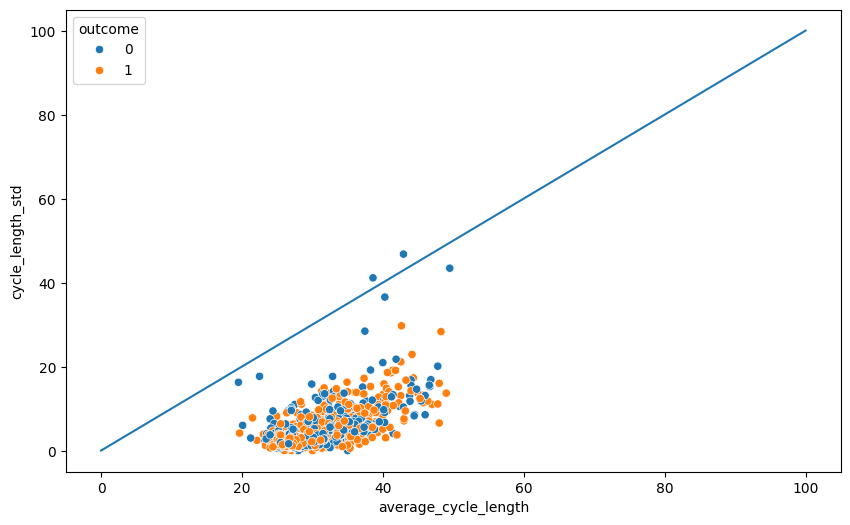

In [321]:
# plot the average_cycle_length against the cycle_length_std
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='average_cycle_length', y='cycle_length_std', hue='outcome')
plt.plot([0,100], [0,100])



In [237]:
# Let's remove the outliers from the average_cycle_length column. Cycles longer than 40 days can be consiered anomalies. 
# Set the threshold to 50 days
df['average_cycle_length'] = df['average_cycle_length'].apply(lambda x: x if x < 50 else np.nan)
df = df.dropna(subset=['average_cycle_length'])


<Axes: >

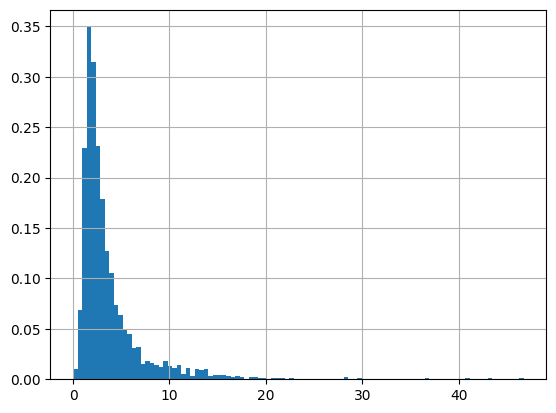

In [238]:
# Given the correlation between the mean and the std, we are also cutting the outliers from the cycle_length_std column


# plot histogram of average cycle lenght
df['cycle_length_std'].hist(bins=100, density=True)





In [239]:
# fit a line to the average_cycle_length and cycle_length_std using scipy and excluding null values
from scipy.stats import linregress
x = df['average_cycle_length']
y = df['cycle_length_std']
mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
slope, intercept

# replace the null values in the cycle_length_std column with the values predicted by the linear regression
df['cycle_length_std'] = df['cycle_length_std'].fillna(df['average_cycle_length'] * slope + intercept)

In [319]:
# Replace the null values in country and been_pregnant_before with 'NS' parameter
df['country'] = df['country'].fillna('NS')
df['been_pregnant_before'] = df['been_pregnant_before'].fillna('NS')
df['education'] = df['education'].fillna('NS')
df['bmi'].replace(0,df['bmi'].mean(), inplace=True)

C:\Users\vbencini\AppData\Local\Temp\ipykernel_11072\2335019441.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].replace(0,df['bmi'].mean(), inplace=True)


In [241]:
# Let's check the frequnecy of each unique value in the sleeping_pattern column
df['sleeping_pattern'].value_counts()

sleeping_pattern
Wake same every workday           795
Several times during the night    245
Wake same every day               211
Shift worker                      144
Late and snoozer                   72
Name: count, dtype: int64

In [242]:
# Let's replace the null values in the sleeping_pattern column with the most frequent value
df['sleeping_pattern'] = df['sleeping_pattern'].fillna('Wake same every workday')

## EDA

Let's plot the cleaned data to check that everything looks fine

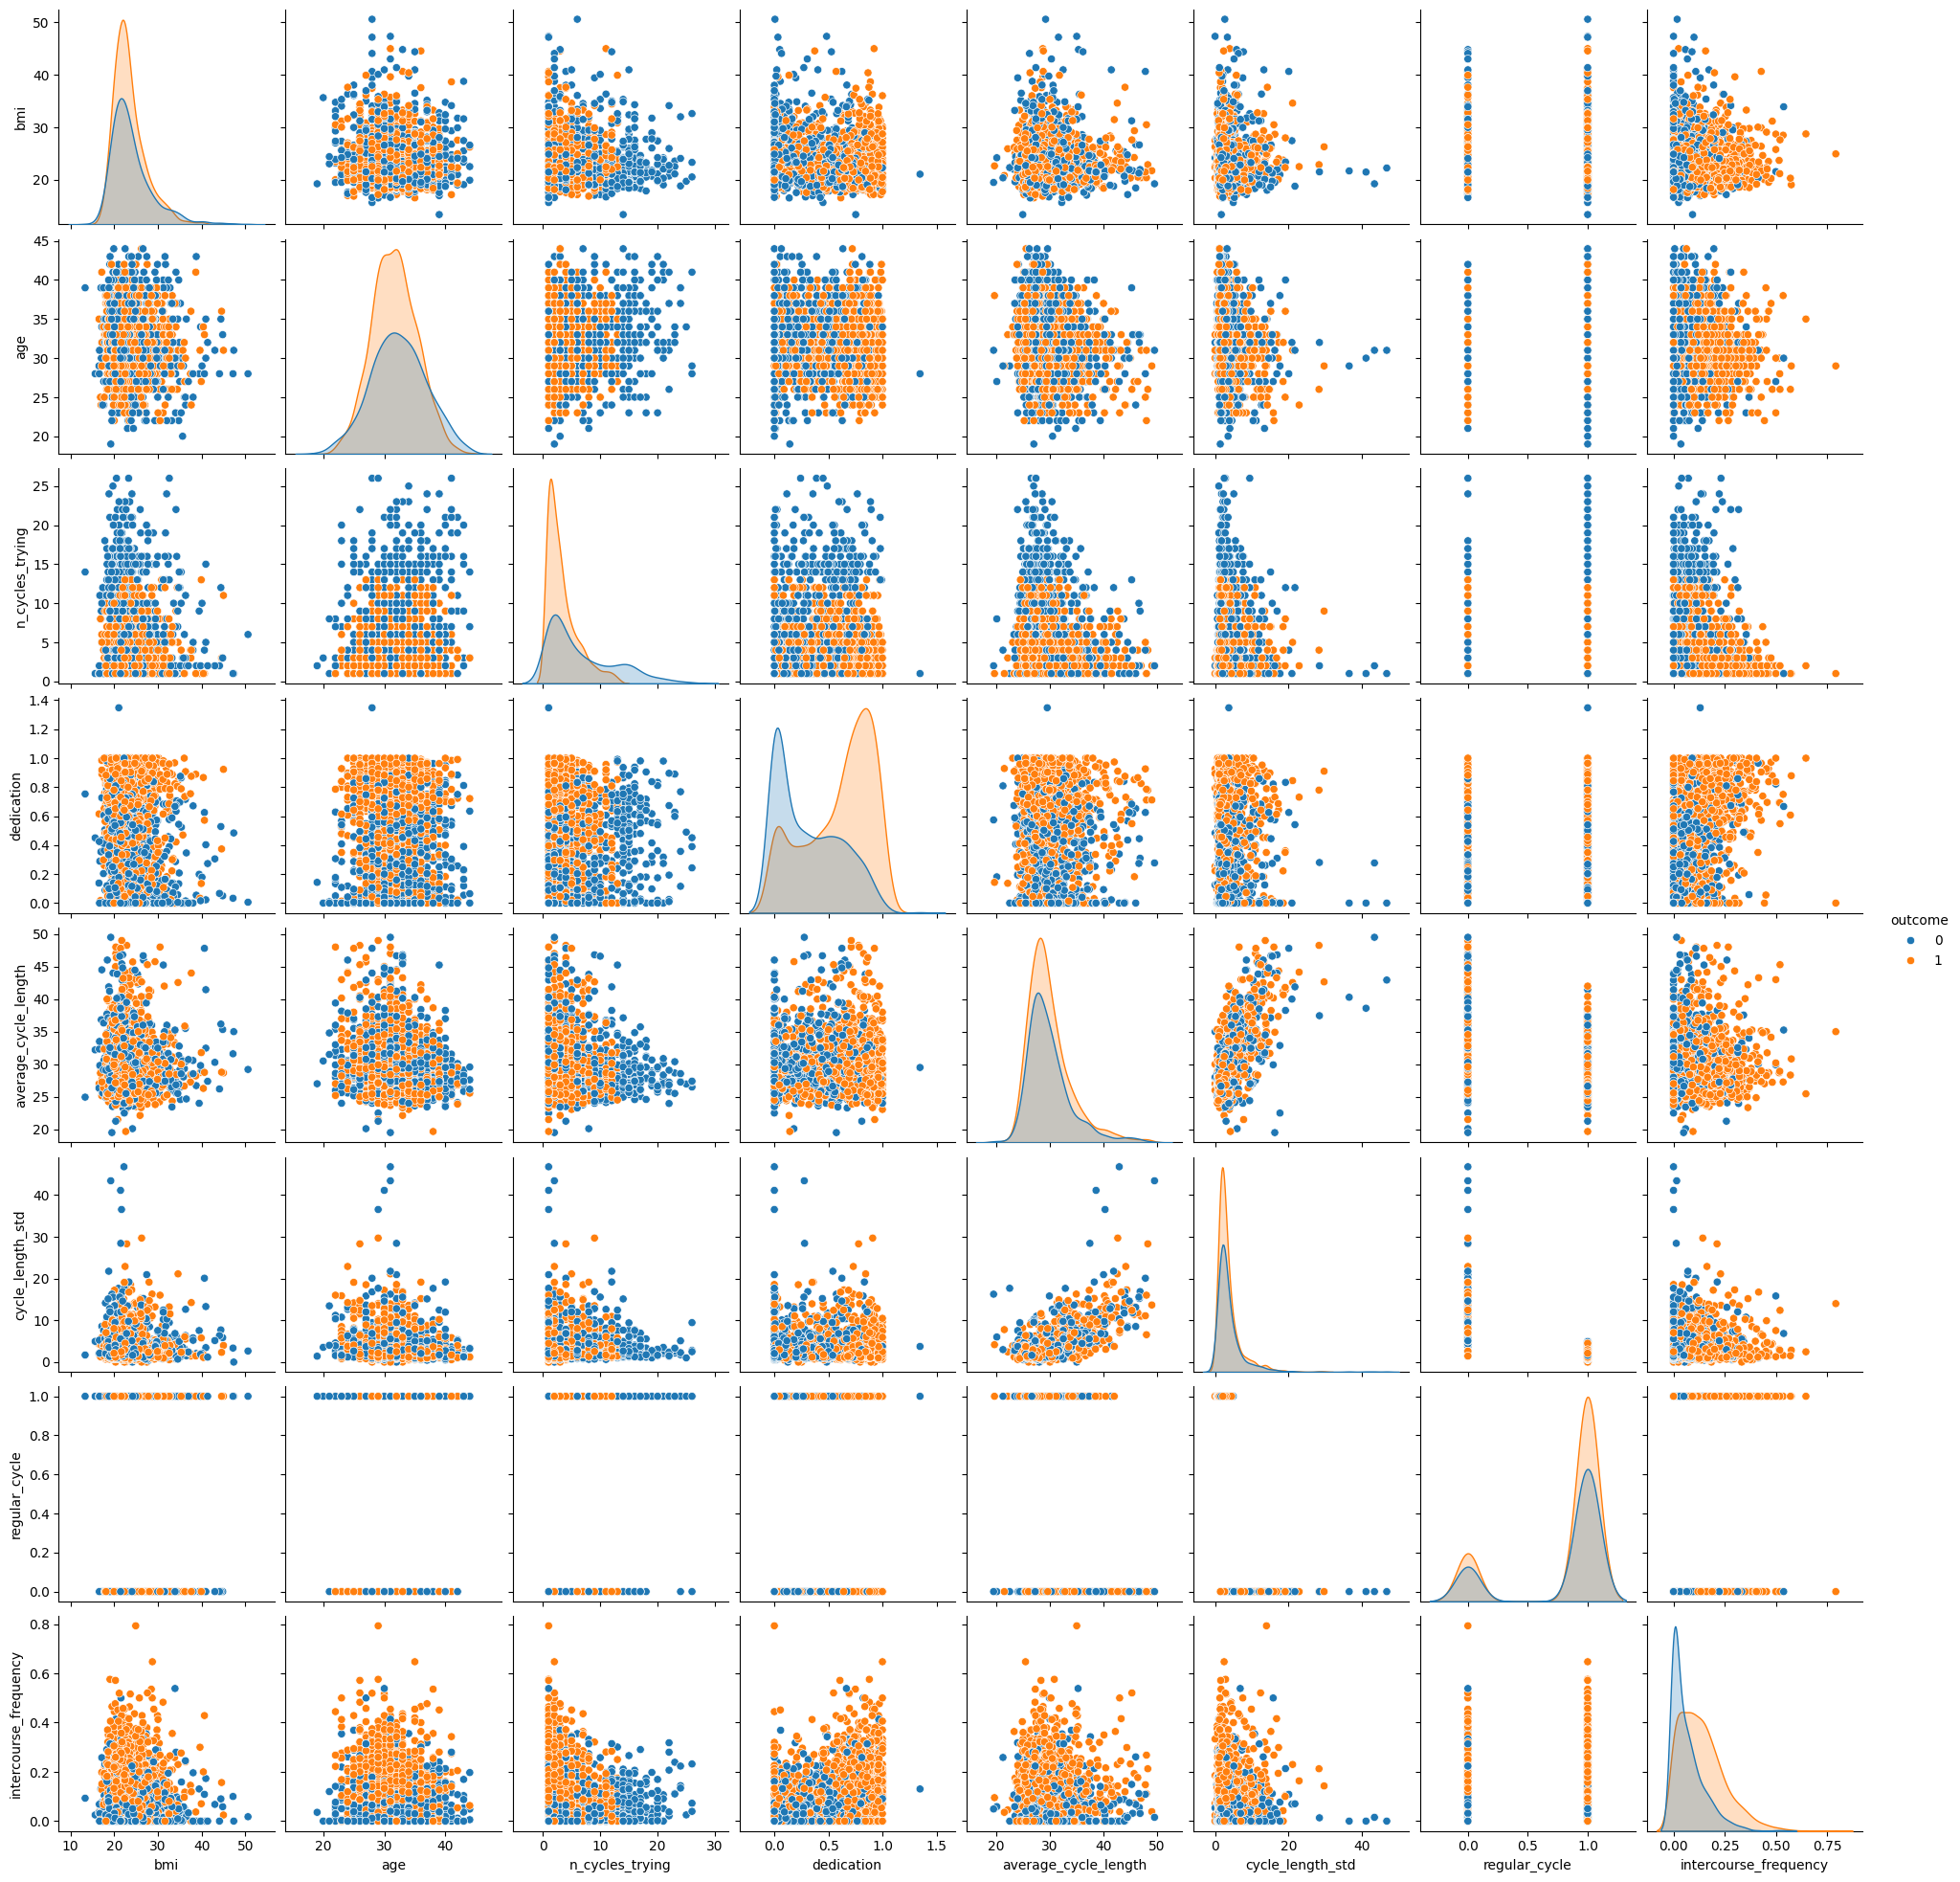

In [320]:
sns.pairplot(df, hue='outcome')

Now let's have a look at the correlation between params

<Axes: >

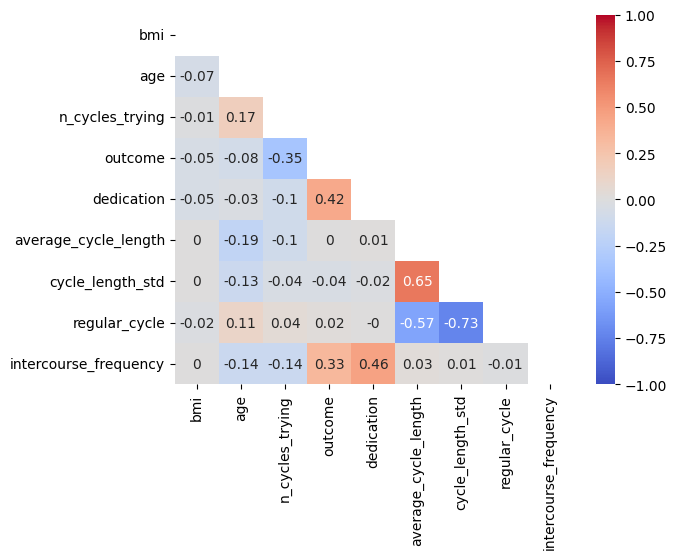

In [323]:
# build a correlation matrix for the features columns and plot the lower diagonal of the matrix
corr = df[features].corr()	
# round the content of corr to 2 decimal places
corr = corr.round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure()
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

## 2 Probability of getting pregnant within 13 cycles




## 2.1 Bayes approach

#### Assumptions

1. Here we consider the provided data to be representative of the population. The probability of getting pregnant is therefore calculated as ratio between successful pregnancy over total number of women on the dataset. 

#### 

To calculate the probaibility of getting pregnant within 13 cycles we use Bayes rule. In particular we consider the two events of interest:

A = Getting pregnant \
B = Number of cycles trying <= 13

We want to calculate:

$ P(A|B) = \frac{P(A)P(B|A)}{P(B)}$

Where

$ P(B|A) = \frac{P(A,B)}{P(A)} $

<Axes: xlabel='n_cycles_trying', ylabel='Count'>

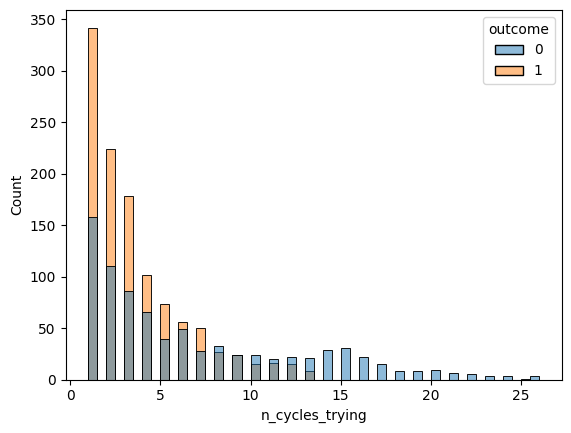

In [387]:
# plot the distribution of the number of cycles trying for each value of outcome
plt.figure()
sns.histplot(data=df, x='n_cycles_trying', hue='outcome', bins=50)

In [388]:

# calculate the ration of values of outcome ==1 to the total number of values in the outcome column

# Probability of getting pregnant:
# This is the number of women who got pregnant divided by the size of the sample population
p_a = df['outcome'].value_counts(normalize=True).loc[1]
print(f"P(A) = {p_a}")

# Probability of n_cycles_trying <=13
# This is the number of women trying for less then 13 cycles divided by size of the sample population
p_b = df[df['n_cycles_trying'] <= 13].shape[0] / df.shape[0]
print(f"P(B) = {p_b}")

# Probability of n_cycles trying<=13 given outome=1
# This is the number of n_cycles_trying <=13 given outcome=1 divided by the number
df_temp = df[df['outcome'] == 1]
df_temp = df_temp[df_temp['n_cycles_trying'] <= 13]
p_a_join_b = df_temp.shape[0] / df.shape[0]
p_b_a = p_a_join_b / p_a
print(f"P(B|A) = {p_b_a}")


p_a_b = (p_a * p_b_a) / p_b

p_a_b


P(A) = 0.5785970302099335
P(B) = 0.926779313876088
P(B|A) = 1.0


0.6243093922651934

<Axes: xlabel='n_cycles_trying', ylabel='Count'>

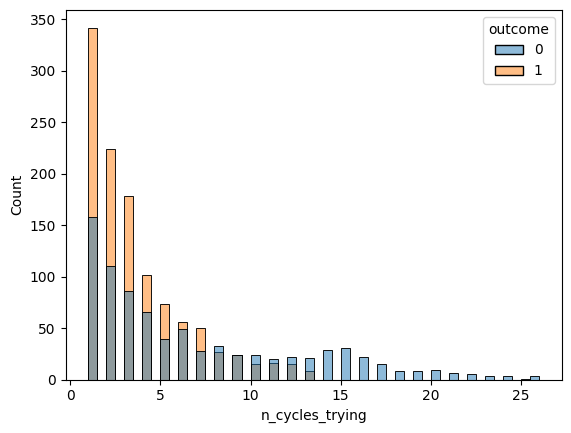

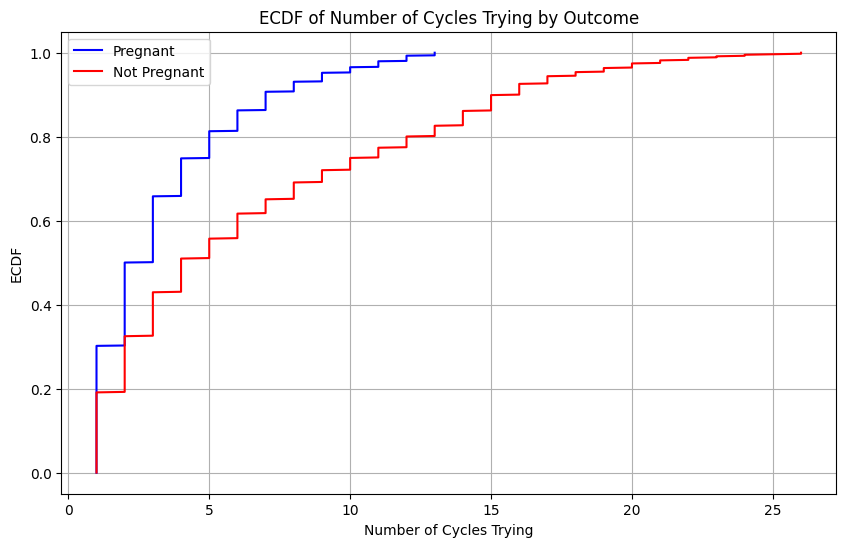

In [343]:

from statsmodels.distributions.empirical_distribution import ECDF
data = df.copy()
# Separate the data based on the outcome
pregnant_data = data[data['outcome'] == 1]['n_cycles_trying']
not_pregnant_data = data[data['outcome'] == 0]['n_cycles_trying']

# Calculate ECDF for each group
ecdf_pregnant = ECDF(pregnant_data)
ecdf_not_pregnant = ECDF(not_pregnant_data)

# Plot the ECDFs
plt.figure(figsize=(10, 6))
plt.plot(ecdf_pregnant.x, ecdf_pregnant.y, label='Pregnant', color='blue')
plt.plot(ecdf_not_pregnant.x, ecdf_not_pregnant.y, label='Not Pregnant', color='red')
plt.title('ECDF of Number of Cycles Trying by Outcome')
plt.xlabel('Number of Cycles Trying')
plt.ylabel('ECDF')
plt.legend()
plt.grid(True)
plt.show()

In [350]:
ecdf_pregnant.y

array([0.00000000e+00, 8.84955752e-04, 1.76991150e-03, ...,
       9.98230088e-01, 9.99115044e-01, 1.00000000e+00])

## 2.2 Considering only women who did not leave before cycle 13

Here we reformulate the problem changing some assumptions:

1. We compute the overall probability of getting pregnant as before
2. We consider as new poulation the women who got pregnant and those who did not stop trying until week 13

In [364]:
# calculate the probability fo getting pregnant within 13 weeks

p_c = 1-p_b

p_a/(p_a+p_c)

0.8876669285153181

In this case the probability of getting pregnant within 13 weeks increses radically. 

## 3 Estimate usual time to pregnancy

1. Select only the positive outcome data
2. Calculate the expected value in days to get pregnant
3. Calculate the variance of number of days to get pregnant

Return mu and sigma 


## 4. Factors influencing the time-to-pregnancy

1. With the new defined value (average days to pregnancy) perform a regression and check for the parameters of major influence
2. In alternative try with PCA
3. Some fancy ML method to account for non linear relationships?

Check statsmodel fscore

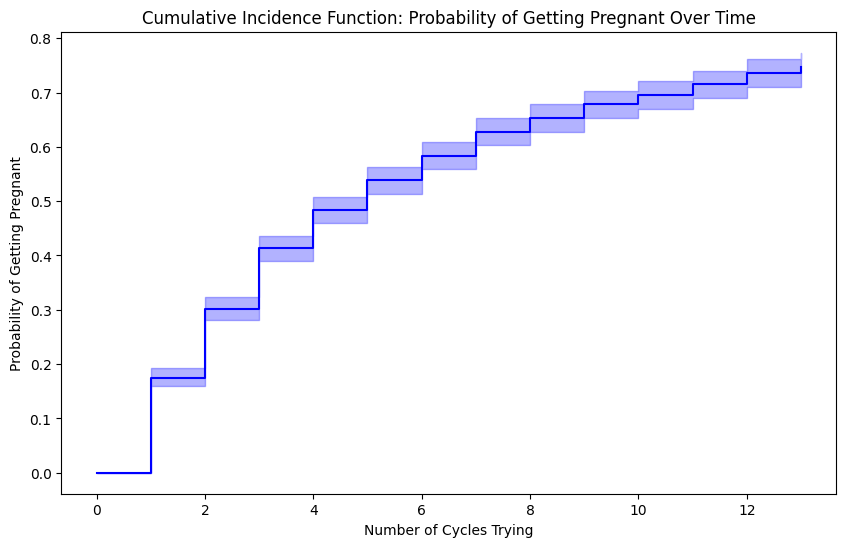

0.747870213004533

In [379]:
from lifelines import KaplanMeierFitter

data = df.copy()
# Create a new column indicating if the data is censored
data['censored'] = ((data['outcome'] == 0) & (data['n_cycles_trying'] <= 13)).astype(int)



# Ensure that observations beyond 13 cycles are censored
data['censored'] = data['censored'] | (data['n_cycles_trying'] > 13)
data.loc[data['n_cycles_trying'] > 13, 'n_cycles_trying'] = 13

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the data
kmf.fit(durations=data['n_cycles_trying'], event_observed=1 - data['censored'])

# Transform the survival function to get the cumulative incidence function
survival_function = kmf.survival_function_
survival_confidence_intervals = kmf.confidence_interval_survival_function_

cumulative_incidence_function = 1 - survival_function
cumulative_incidence_confidence_intervals = 1 - survival_confidence_intervals

# Plot the cumulative incidence function with confidence intervals
plt.figure(figsize=(10, 6))
plt.step(cumulative_incidence_function.index, cumulative_incidence_function['KM_estimate'], where="post", label='Cumulative Incidence', color='blue')
plt.fill_between(cumulative_incidence_confidence_intervals.index,
                 cumulative_incidence_confidence_intervals['KM_estimate_lower_0.95'],
                 cumulative_incidence_confidence_intervals['KM_estimate_upper_0.95'],
                 step="post", alpha=0.3, color='blue')

plt.title('Cumulative Incidence Function: Probability of Getting Pregnant Over Time')
plt.xlabel('Number of Cycles Trying')
plt.ylabel('Probability of Getting Pregnant')
# plt.legend()
# plt.grid(True)
plt.show()


# Calculate the probability of getting pregnant within 13 cycles
probability_pregnant_within_13_cycles = cumulative_incidence_function.loc[13, 'KM_estimate']
probability_pregnant_within_13_cycles


<Axes: xlabel='n_cycles_trying'>

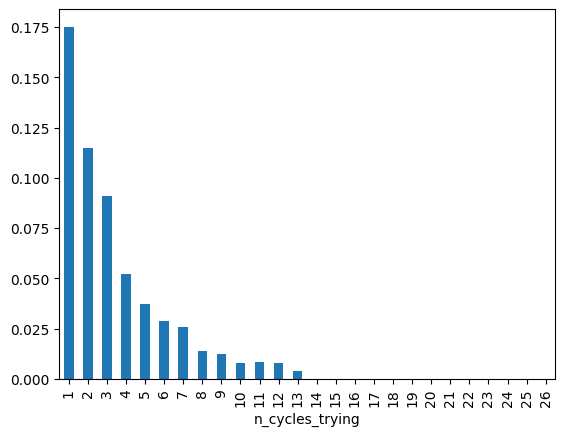

In [386]:
# calculate and plot the ration between pregnant and non pregnant women for each n_cycles_trying
df_temp = df.groupby('n_cycles_trying')['outcome'].value_counts().unstack()   
df_temp['ratio'] = df_temp[1] / df.shape[0]
plt.figure()
df_temp['ratio'].plot(kind='bar')


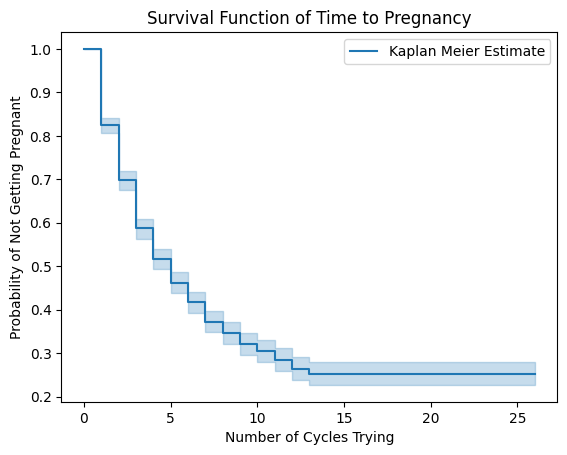

In [313]:
kmf.plot_survival_function(ci_show=True)
plt.title('Survival Function of Time to Pregnancy')
plt.xlabel('Number of Cycles Trying')
plt.ylabel('Probability of Not Getting Pregnant')
plt.show()

<lifelines.CoxPHFitter: fitted with 1953 total observations, 823 right-censored observations>
             duration col = 'n_cycles_trying'
                event col = 'outcome'
      baseline estimation = breslow
   number of observations = 1953
number of events observed = 1130
   partial log-likelihood = -7614.54
         time fit was run = 2024-05-14 11:13:03 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
bmi                    0.00      1.00      0.01           -0.01            0.01                0.99                1.01
age                   -0.03      0.97      0.01           -0.05           -0.02                0.95                0.98
dedication             1.26      3.53      0.11            1.04            1.48                2.84                4.38
average_cycle_length   0.02      1.02      0.01            0.00            0.04                1.00                1.05
cycle_length_std      -0.05      0.96      0.02           -0.08           -0.01                0.92                0.99
regular_cycle         -0.03      0.97      0.12           -0.27            0.21                0.76                1.23
intercourse_frequency  2.59     13.32      0.30            2.00            3.18                7.39               24.00

                       cmp to     z      p  -log2(p)
covariate                                           
bmi                      0.00  0.04   0.97      0.05
age                      0.00 -4.39 <0.005     16.42
dedication               0.00 11.36 <0.005     96.86
average_cycle_length     0.00  2.36   0.02      5.77
cycle_length_std         0.00 -2.63   0.01      6.88
regular_cycle            0.00 -0.25   0.80      0.32
intercourse_frequency    0.00  8.61 <0.005     56.95
---
Concordance = 0.70
Partial AIC = 15243.08
log-likelihood ratio test = 394.38 on 7 df
-log2(p) of ll-ratio test = 267.14

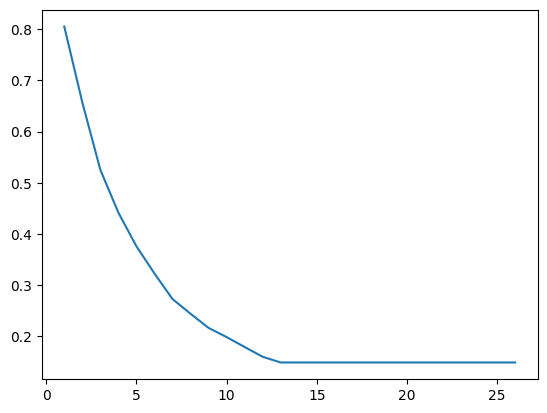

In [268]:
import pandas as pd
from lifelines import CoxPHFitter


# Select relevant features and encode categorical variables
features = ['bmi', 'age', 'n_cycles_trying', 'outcome', 'dedication',
       'average_cycle_length', 'cycle_length_std', 'regular_cycle',
       'intercourse_frequency']


data = df[features]
# data_encoded = pd.get_dummies(data, columns=['country', 'education', 'sleeping_pattern','been_pregnant_before'], drop_first=True)

# Initialize the CoxPHFitter
cph = CoxPHFitter()

# Fit the model on the data
cph.fit(data, duration_col='n_cycles_trying', event_col='outcome')

# Print the summary
cph.print_summary()

# Predict the survival function for a sample set of covariates
sample_covariates = data_encoded.iloc[0][features]  # Example: using the first row as a sample
survival_function = cph.predict_survival_function(sample_covariates)
plt.plot(survival_function)


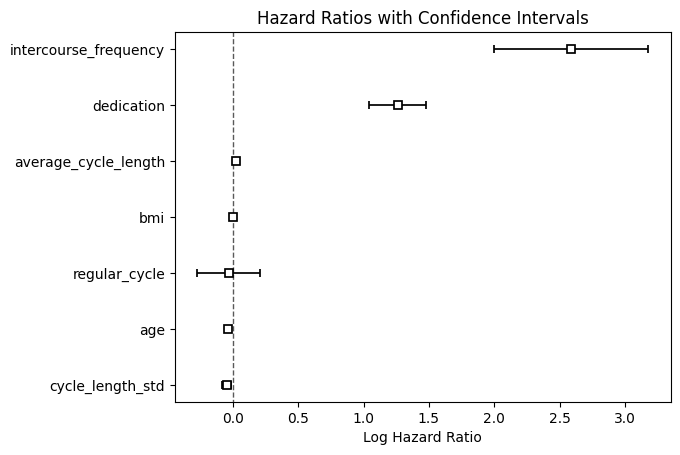

In [265]:
# Plot the coefficients (log hazard ratios) with confidence intervals
cph.plot()
plt.title('Hazard Ratios with Confidence Intervals')
plt.xlabel('Log Hazard Ratio')
plt.show()

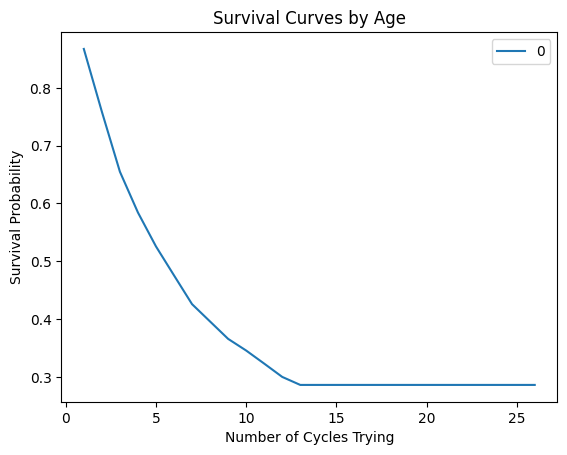

In [282]:
# Create a new dataframe for age ranges
age_quantiles = df['age'].quantile([0.25, 0.5, 0.75]).values
median_values = data.mean()
age_ranges_df = pd.DataFrame({
    'age': age_quantiles,
    'bmi': median_values['bmi'],
    'dedication': median_values['dedication'],
    'average_cycle_length': median_values['average_cycle_length'],
    'cycle_length_std': median_values['cycle_length_std'],
    'regular_cycle': median_values['regular_cycle'],
    'intercourse_frequency': median_values['intercourse_frequency']
    # Add other covariates with their median values as needed
})

# Use as input the median of all features
survival_function = cph.predict_survival_function(median_values)
survival_function.plot()
# Plot the survival curves for different age ranges
# fig, ax = plt.subplots()

# for i, row in age_ranges_df.iterrows():
#     survival_function = cph.predict_survival_function(row)
#     survival_function.plot(ax=ax, label=f'Age {row["age"]}')
# ax.legend()

plt.title('Survival Curves by Age')
plt.xlabel('Number of Cycles Trying')
plt.ylabel('Survival Probability')
# plt.legend()
plt.show()

In [278]:
age_ranges_df

,age,bmi,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency
0,29.0,22.547953,0.511278,28.894737,2.519157,1.0,0.08046
1,32.0,22.547953,0.511278,28.894737,2.519157,1.0,0.08046
2,35.0,22.547953,0.511278,28.894737,2.519157,1.0,0.08046
